[Link](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788)
[link2](https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051)

 # ARIMA
ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
- A weighted sum of lagged values of the series (Auto-regressive (AR) part)
- A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
- A difference of the time series (Integrated (I) part)

An ARIMA model is often noted ARIMA(p, d, q) where p represents the order of the AR part, d the order of differencing (“I” part), and q the order of the MA term.

In [33]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal
from sklearn.metrics import mean_squared_error

import numpy as np
%matplotlib inline
plt.style.use('Solarize_Light2')

In [2]:
def preprocess(dx):
    # only filter final DOA
    dx = dx[dx['DBA']==89]
    dx = dx.set_index('DOA')
    dx = dx.asfreq(freq='d', method='ffill')
    dx = dx.reset_index('DOA')
    # Normalize Rooms 
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # Normalize ROH 
    dx.loc[dx['ROH']==0,'ROH'] = dx['ROH'].median()

    # convert to OCC
    dx['ROH'] = dx['ROH']/dx['Rooms']
    dx.loc[dx['ROH']>1,'ROH'] = 1.0
    dx = dx.drop(columns=['DBA','LAR','ADR','Rooms'])
    dx = dx.set_index('DOA')
    dx = dx.asfreq(freq='D', method='ffill')
    return dx

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

In [3]:
df = pd.read_pickle('dataset/preprocessed/48_imputed.pkl')
df = preprocess(df)
train, test = train_test_split(df)

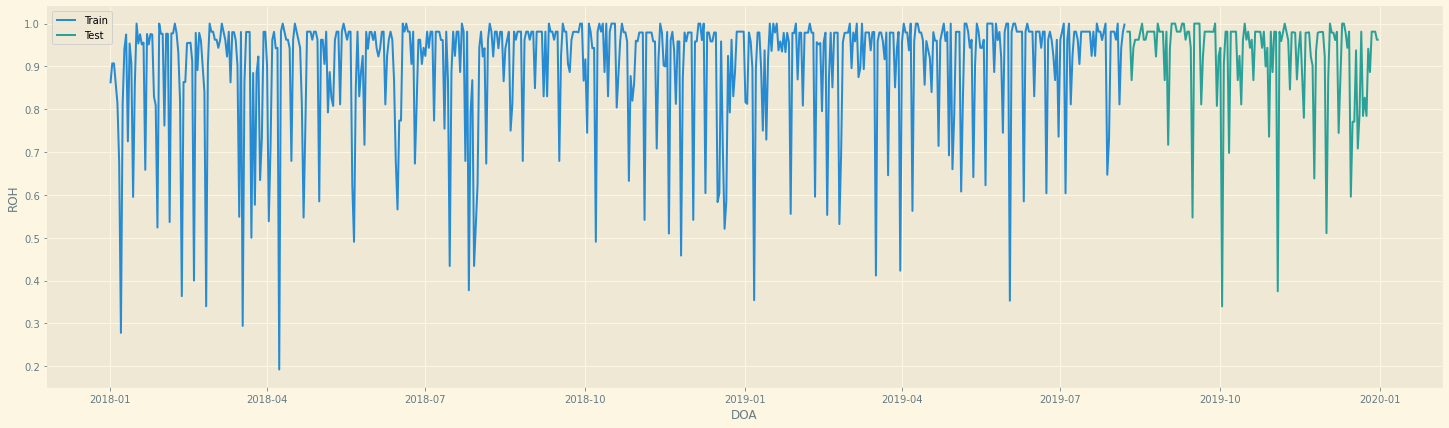

In [31]:
plt.figure(figsize=(25,7))
plt.plot(train.index, train['ROH'], label='Train')
plt.plot(test.index, test['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

## 1) Choosing the differencing order
The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. To do that, we look at the ACF and PACF plots, and keep in mind these two rules:

- Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing. 
- Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.” 
(Robert Nau, Statistical Forecasting)

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

(1.0, 5.0)

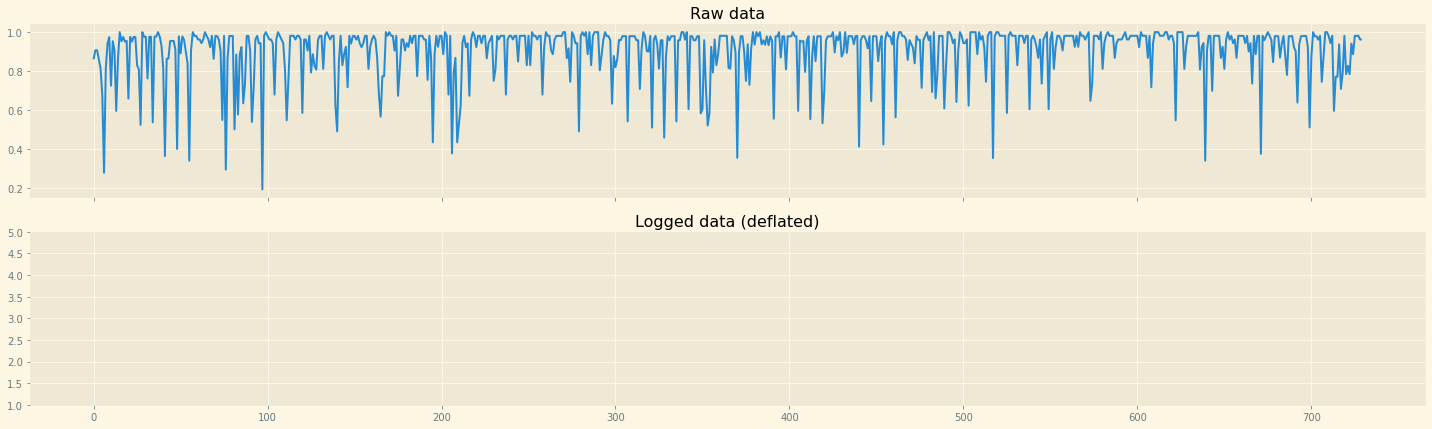

In [33]:
# Raw trends 
fig, ax = plt.subplots(2, sharex=True, figsize=(25,7))
ax[0].plot(df.ROH.values)
ax[0].set_title("Raw data")
ax[1].plot(np.log(df.ROH.values))
ax[1].set_title("Logged data (deflated)")
ax[1].set_ylim(1, 5)

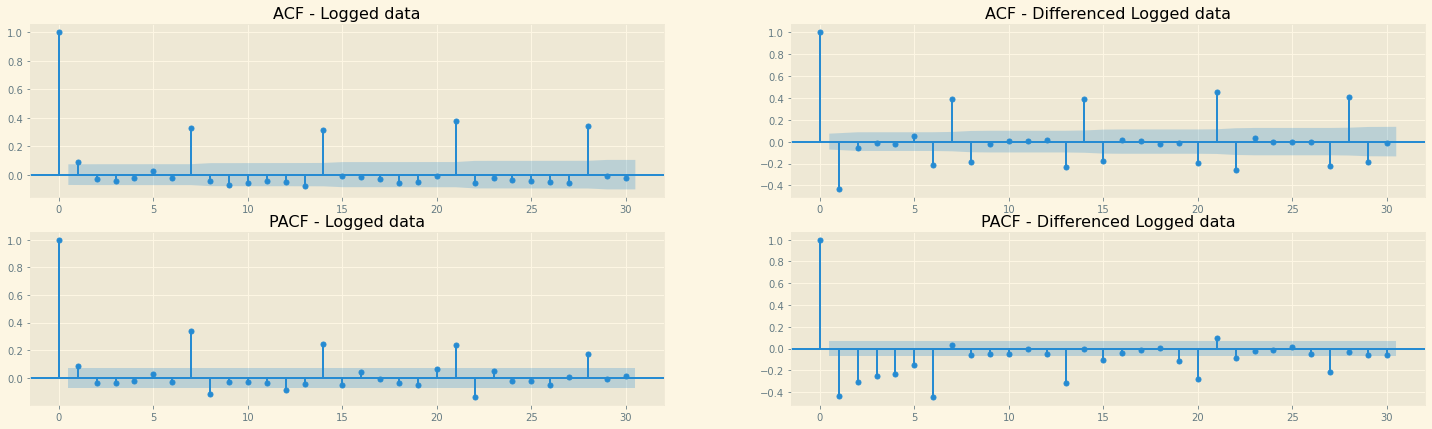

In [34]:
# fig, ax = plt.subplots(2, 2, figsize=(25,7))
# first_diff = (np.log(df.ROH)- np.log(df.ROH).shift()).dropna()
# ax[0, 0] = plot_acf(np.log(df.ROH), ax=ax[0, 0], lags=30, title="ACF - Logged data")
# ax[1, 0] = plot_pacf(np.log(df.ROH), ax=ax[1, 0], lags=30, title="PACF - Logged data")
# ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=30, title="ACF - Differenced Logged data")
# ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=30, title="PACF - Differenced Logged data")


fig, ax = plt.subplots(2, 2, figsize=(25,7))
first_diff = (df.ROH - df.ROH.shift()).dropna()
ax[0, 0] = plot_acf(df.ROH, ax=ax[0, 0], lags=30, title="ACF - Logged data")
ax[1, 0] = plot_pacf(df.ROH, ax=ax[1, 0], lags=30, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=30, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=30, title="PACF - Differenced Logged data")

In [36]:
# from statsmodels.tsa.stattools import kpss

# print(" > Is the data stationary ?")
# dftest = kpss(np.log(df.ROH), 'ct')
# print("Test statistic = {:.3f}".format(dftest[0]))
# print("P-value = {:.3f}".format(dftest[1]))
# print("Critical values :")
# for k, v in dftest[3].items():
#     print("\t{}: {}".format(k, v))

from statsmodels.tsa.stattools import kpss

print(" > Is the data stationary ?")
dftest = kpss(df.ROH, 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.089
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [39]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.ROH.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df.ROH.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())


                              ARMA Model Results                              
Dep. Variable:                    ROH   No. Observations:                  730
Model:                     ARMA(0, 0)   Log Likelihood                 410.692
Method:                           css   S.D. of innovations              0.138
Date:                Fri, 15 Jan 2021   AIC                           -817.384
Time:                        05:16:26   BIC                           -808.197
Sample:                    01-01-2018   HQIC                          -813.839
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9048      0.005    177.336      0.000       0.895       0.915
                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observat

The Akaike Information Criterion (AIC) is lower with the ARIMA(0,1,0), meaning this model is performing better than the ARIMA(0,0,0). Let’s have a look at the residuals and check their variance:

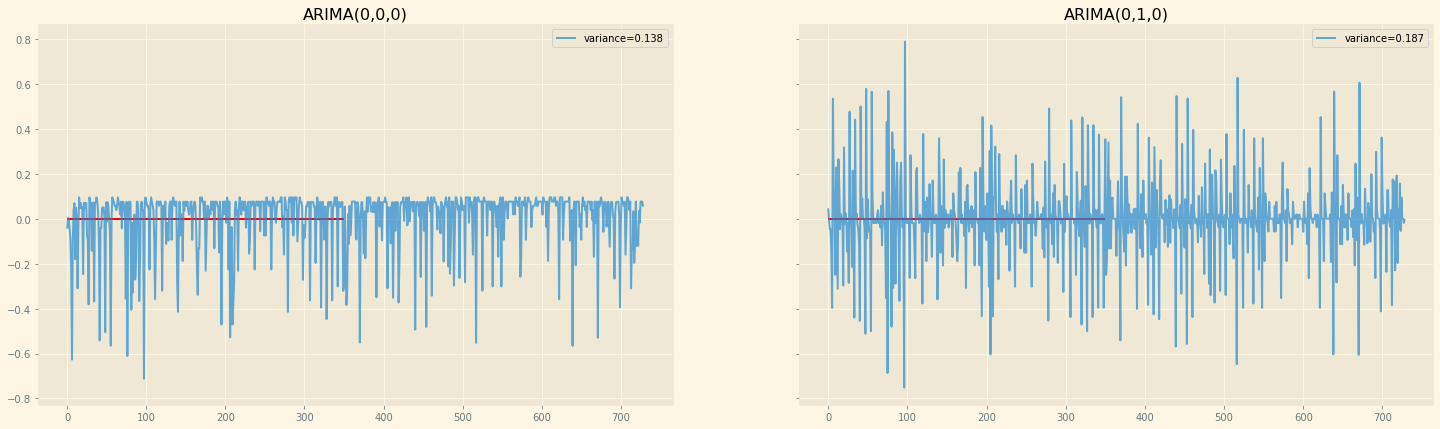

In [40]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(25, 7))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=350, color='r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=350, color='r')
ax[1].set_title("ARIMA(0,1,0)")
ax[1].legend()

## 2) Choosing the MA order
- If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1
- Notice how the AIC has dropped again, and how the residuals variance decreased. That’s a sign our (1,1,0) ARIMA is performing better than the (0,1,0) model !

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  729
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 266.570
Method:                       css-mle   S.D. of innovations              0.168
Date:                Fri, 15 Jan 2021   AIC                           -527.140
Time:                        05:21:47   BIC                           -513.365
Sample:                    01-02-2018   HQIC                          -521.826
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0001      0.004      0.028      0.978      -0.008       0.009
ar.L1.D.ROH    -0.4358      0.033    -13.091      0.000      -0.501      -0.371
                                    Roots       

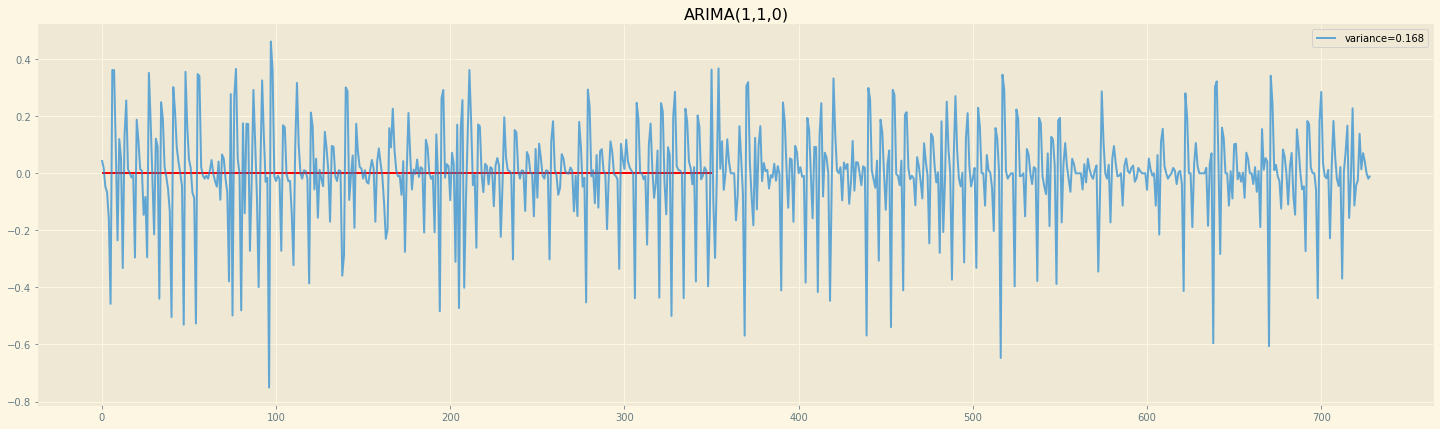

In [45]:
model = ARIMA(df.ROH.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)))
ax.hlines(0, xmin=0, xmax=350, color='r')
ax.set_title("ARIMA(1,1,0)")
ax.legend()

# 3) Choosing the AR order
- If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  729
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 414.075
Method:                       css-mle   S.D. of innovations              0.137
Date:                Fri, 15 Jan 2021   AIC                           -820.150
Time:                        05:24:04   BIC                           -801.784
Sample:                    01-02-2018   HQIC                          -813.064
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.243e-05   2.58e-05      3.190      0.001    3.18e-05       0.000
ar.L1.D.ROH     0.0724      0.037      1.959      0.050   -4.62e-05       0.145
ma.L1.D.ROH    -1.0000      0.004   -223.551    

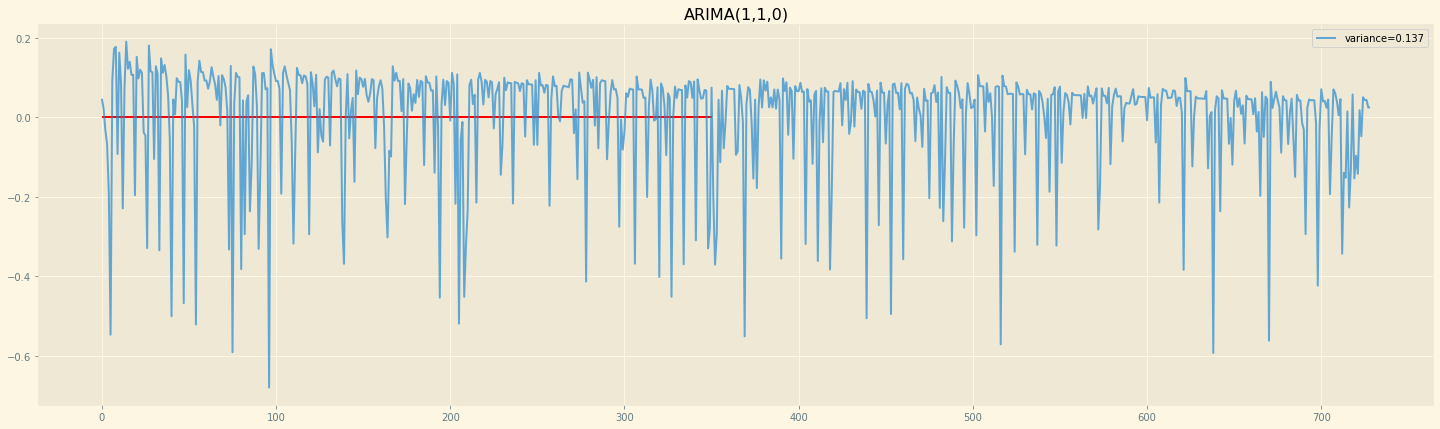

In [46]:
model = ARIMA(df.ROH.dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)))
ax.hlines(0, xmin=0, xmax=350, color='r')
ax.set_title("ARIMA(1,1,0)")
ax.legend()

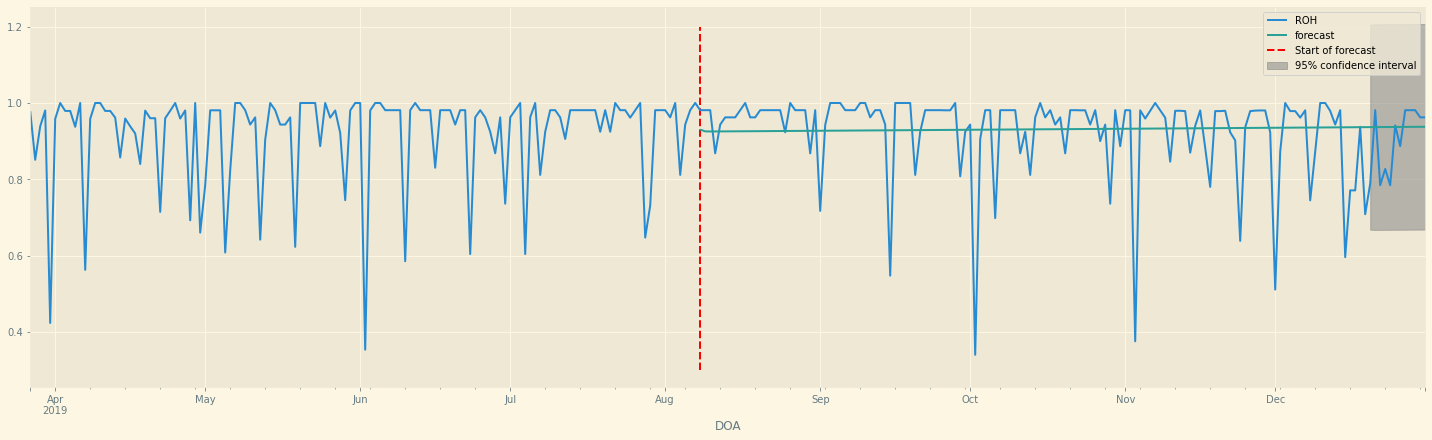

In [69]:
model = ARIMA(df.ROH.dropna()[:-12], (1, 1, 1))
res_111 = model.fit()

fig, ax = plt.subplots(figsize=(25, 7))
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.ROH.dropna()[450:].plot(ax=ax)
ax.vlines('2019-08-08', 0.3, 1.2, linestyle='--', color='r', label='Start of forecast')

# # - NOTE from the official documentation :
# # -- The dynamic keyword affects in-sample prediction. 
# # -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# # -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.
ax = res_111.plot_predict('2019-08-08', '2019-12-31', dynamic=True, plot_insample=False, ax=ax)

# SARIMA

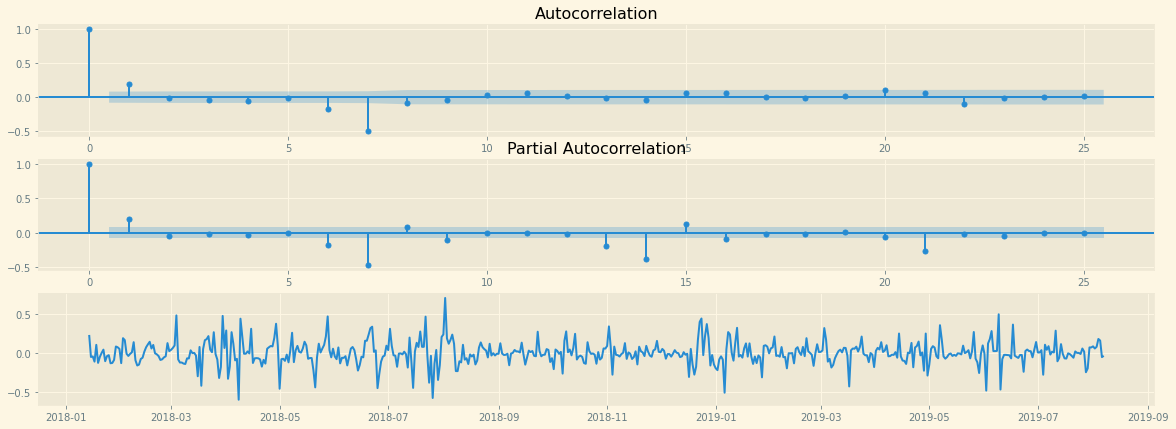

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Stationary data
# df['station'] = df.ROH - df.ROH.rolling(7).mean()

# fig, ax = plt.subplots(3, figsize=(20,7))
# x = (df.station.dropna() - df.station.dropna().shift(7)).dropna()
# ax[0] = plot_acf(x, ax=ax[0], lags=25)
# ax[1] = plot_pacf(x, ax=ax[1], lags=25)
# ax[2].plot(x)

# Stationary data
train['station'] = train.ROH - train.ROH.rolling(7).mean()

fig, ax = plt.subplots(3, figsize=(20,7))
x = (train.station.dropna() - train.station.dropna().shift(7)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# train_st = df[:146]["station"]
# test_st  = df[146:]["station"]
# sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 7), enforce_invertibility=False, enforce_stationarity=False)
# sarima_fit = sarima_model.fit()

train_st = train["station"]
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 7), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

In [13]:
# sarima_pred = sarima_fit.get_prediction("2019-08-08", "2019-12-31")
# predicted_means = sarima_pred.predicted_mean + df['2019-08-08':]['ROH'].rolling(7).mean().values
# predicted_intervals = sarima_pred.conf_int(alpha=0.05)
# lower_bounds = predicted_intervals['lower station'] + df['2019-08-08':]['ROH'].rolling(7).mean().values
# upper_bounds = predicted_intervals['upper station'] + df['2019-08-08':]['ROH'].rolling(7).mean().values

sarima_pred = sarima_fit.get_prediction("2019-08-08", "2019-12-31")
predicted_means = sarima_pred.predicted_mean + train['ROH'].rolling(7).mean().dropna().values[-146:]
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]
upper_bounds = predicted_intervals['upper station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]

Text(0.5, 1.0, 'SARIMA')

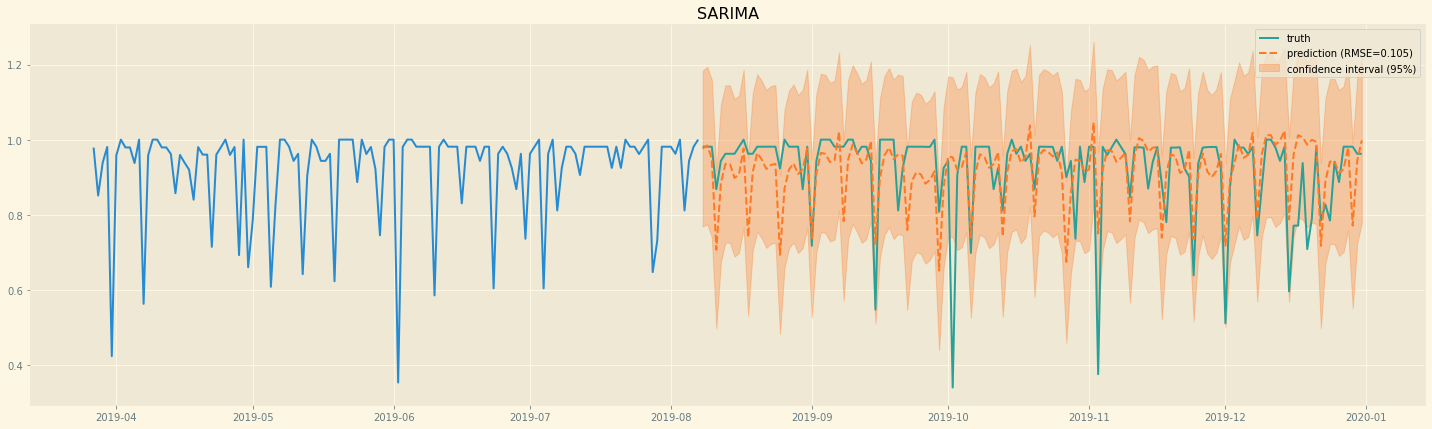

In [38]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(df.ROH.index[450:-146], df.ROH.values[450:-146])
ax.plot(test['2019-08-08':].index, test['ROH'].values, label='truth')
ax.plot(test['2019-08-08':].index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.3f})".format(0.1052))
ax.fill_between(test['2019-08-08':].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("SARIMA")

In [30]:
predicted_means

2019-08-08    0.976162
2019-08-09    0.984310
2019-08-10    0.949956
2019-08-11    0.706756
2019-08-12    0.883878
                ...   
2019-12-27    0.921498
2019-12-28    0.979564
2019-12-29    0.770939
2019-12-30    0.944188
2019-12-31    0.998128
Freq: D, Name: predicted_mean, Length: 146, dtype: float64

In [34]:
rmse = mean_squared_error(test['ROH'].values, predicted_means, squared=False)
mape = np.mean(np.abs((predicted_means-test['ROH'].values)/test['ROH'].values)) # mape

In [35]:
print(round(rmse,4),'\t& ',round(mape,4))

0.1052 	&  0.0915


In [1]:
from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

ImportError: cannot import name 'mean_absolute_percentage_error' from 'sklearn.metrics' (/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [2]:
mean_absolute_error(y_true, y_pred)

0.5

In [3]:
mean_absolute_percentage_error(y_true, y_pred)

NameError: name 'mean_absolute_percentage_error' is not defined